In [ ]:
import os
import pandas as pd
import numpy as np
import gpflow
import matplotlib as mpl
mpl.rc("figure", figsize=(10, 10))
mpl.rcParams.update({'font.size': 10})
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
from mpl_toolkits.basemap import Basemap
from src.plotting_functions import pcolormesh_df

base_path = '/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/'
folders = ['Randomly_Distributed_Observations_100','Land_Only_Distributed_Observations_100']

2022-05-18 12:31:32.027471: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 12:31:32.027598: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# Loading and displaying model summary statistics
df_model_summarys = []
for folder in folders:    
    model_summary_obj = np.load(f'{base_path}{folder}/AP_GPLima_MCMC_Alpha_Model_Summary.npy',allow_pickle=True)
    model_summary_dict = dict(zip(model_summary_obj[:,0], model_summary_obj[:,1]))
    parameters = ['kernel_variance','kernel_lengthscales','likelihood_variance']
    df_model_summary = pd.DataFrame(np.array([model_summary_dict[param].ravel() for param in parameters]).T,columns=parameters)
    df_model_summary['folder']=folder
    df_model_summarys.append(df_model_summary)
df_model_summarys = pd.concat(df_model_summarys)

In [ ]:
df_model_summary_rand = df_model_summarys[df_model_summarys['folder']=='Randomly_Distributed_Observations_100']

In [ ]:
df_model_summary_rand.describe()

,kernel_variance,kernel_lengthscales,likelihood_variance
count,500.000000,500.000000,500.000000
mean,1.441468,0.420526,0.019891
std,0.634765,0.227416,0.033961
min,0.652053,0.123904,0.000120
25%,0.962924,0.248103,0.001023
50%,1.232283,0.338702,0.003431
75%,1.720843,0.522093,0.023595
max,3.569865,1.177610,0.190564


<AxesSubplot:ylabel='Frequency'>

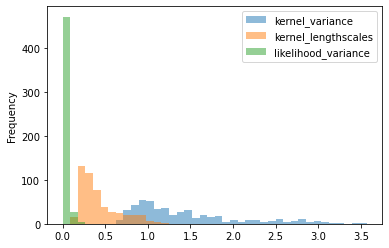

In [ ]:
df_model_summary_rand.plot.hist(bins=40,alpha=0.5)

In [ ]:
# Recreating the kernel object used with the estimated variance and lengthscales
kern = gpflow.kernels.Matern32(lengthscales=df_model_summary_rand['kernel_lengthscales'].mean(),variance=df_model_summary_rand['kernel_variance'].mean())

2022-05-18 12:31:39.601198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 12:31:39.601247: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 12:31:39.601281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab-biascorrlab-6d455bbdbd-q4q2d): /proc/driver/nvidia/version does not exist
2022-05-18 12:31:39.601619: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


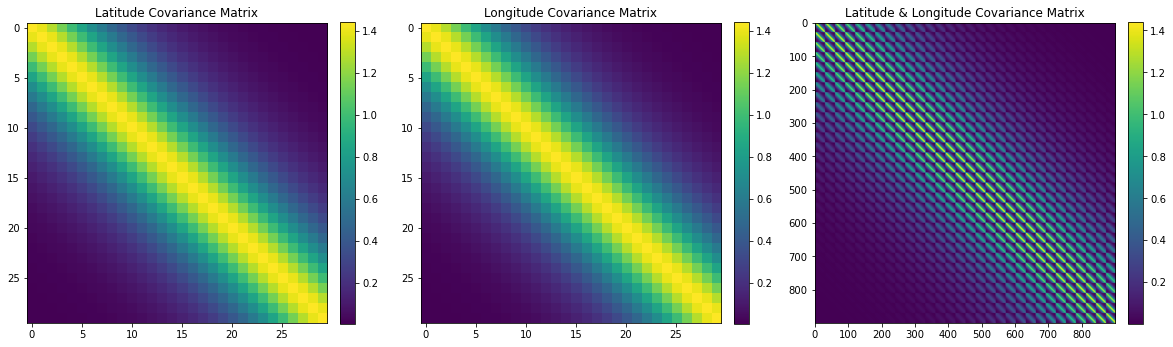

In [ ]:
# Plotting the covariance matrix representation of the kernel.
xs = np.linspace(-1, 1, 30).reshape(-1, 1)
xs_grid = np.meshgrid(xs,xs)
zeros = np.zeros(xs.shape)
fig, axs = plt.subplots(1,3,figsize=(20,10))
plt1 = axs[0].imshow(kern(np.hstack((xs,zeros))))
axs[0].set_title('Latitude Covariance Matrix')
plt2 = axs[1].imshow(kern(np.hstack((zeros,xs))))
axs[1].set_title('Longitude Covariance Matrix')
plt3 = axs[2].imshow(kern(np.hstack((xs_grid[0].reshape(-1,1),xs_grid[1].reshape(-1,1)))))
axs[2].set_title('Latitude & Longitude Covariance Matrix')

for plot,ax in zip([plt1,plt2,plt3],axs):
    fig.colorbar(plot,ax=ax,fraction=0.046, pad=0.04)

Text(0.5, 1.0, 'Latitude & Longitude MVN Example')

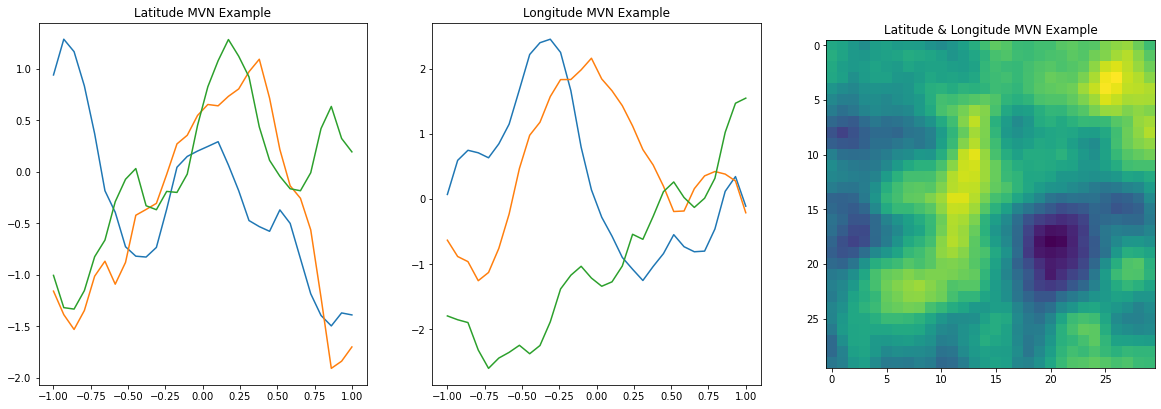

In [ ]:
# Plotting MVN Function Realisations of the Kernel
xs = np.linspace(-1, 1, 30).reshape(-1, 1)
xs_grid = np.meshgrid(xs,xs)
zeros = np.zeros(xs.shape)
fig, axs = plt.subplots(1,3,figsize=(20,6.66))
mean_vector = np.zeros(len(xs))
covariance_matrix = kern(np.hstack((xs,zeros)))  
MVN_values = np.random.multivariate_normal(mean_vector, covariance_matrix, 3).T
axs[0].plot(xs, MVN_values)
axs[0].set_title('Latitude MVN Example')
covariance_matrix = kern(np.hstack((zeros,xs)))
MVN_values = np.random.multivariate_normal(mean_vector, covariance_matrix, 3).T
axs[1].plot(xs, MVN_values)
axs[1].set_title('Longitude MVN Example')
xs_grid_reshaped = np.hstack((xs_grid[0].reshape(-1,1),xs_grid[1].reshape(-1,1)))
mean_vector = np.zeros(xs_grid[0].flatten().shape[0])
covariance_matrix = kern(xs_grid_reshaped)
MVN_values = np.random.multivariate_normal(mean_vector, covariance_matrix)
MVN_values_reshaped = MVN_values.reshape(xs.shape[0],xs.shape[0])
axs[2].imshow(MVN_values_reshaped)
axs[2].set_title('Latitude & Longitude MVN Example')

In [ ]:
mean_vector.shape

(900,)

In [ ]:
covariance_matrix.shape

TensorShape([900, 900])

In [ ]:
MVN_values.shape

(900,)

In [ ]:
np.random.multivariate_normal(mean_vector, covariance_matrix).shape

(900,)

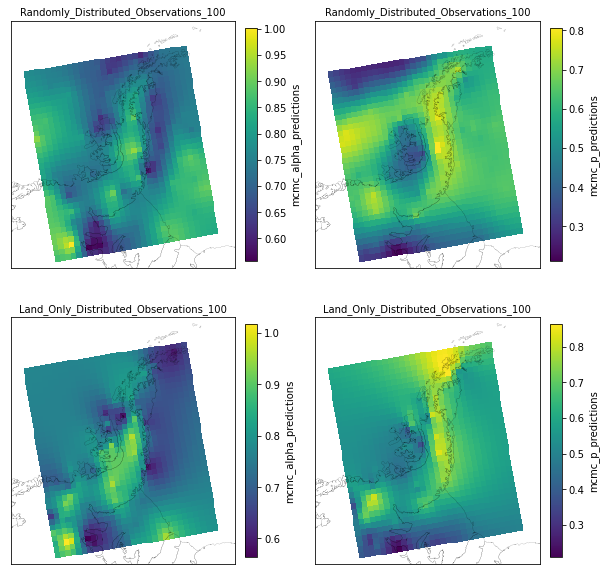

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
antarctica_peninsula_map = Basemap(width=2000000,height=2200000,projection='laea',lat_ts=-55,lat_0=-71,lon_0=-67,resolution='l')
parameters = ['mcmc_alpha_predictions','mcmc_p_predictions']
counter=1
for folder in folders: 
    for param in parameters:
        df = pd.read_csv(f'{base_path}{folder}/AP_BGLima_Snowfall_044_Mean_Alpha_stand_All.csv', index_col=0) 
        plt.subplot(2,2,counter)
        pcolormesh_df(df.groupby(['grid_latitude','grid_longitude']).mean(),f'{param}',antarctica_peninsula_map)
        plt.title(f'{folder}',fontsize=10,color='k')
        plt.colorbar(fraction=0.046, pad=0.04,label=f'{param}')
        counter+=1
plt.show()